## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Check the shape
data.shape

(167, 10)

In [5]:
# Check datatypes
data.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [6]:
# Check counts
data.count()

country       167
child_mort    167
exports       167
health        167
imports       167
income        167
inflation     167
life_expec    167
total_fer     167
gdpp          167
dtype: int64

In [7]:
# Get descriptive statistics
data.describe(include='all')

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
unique,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,NaN,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,NaN,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,NaN,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,NaN,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,NaN,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000


In [8]:
# Identify any missing data
missing_data = data.isnull().sum()
missing_data

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [9]:
# Drop any non-numeric features (columns)
data.drop('country', axis=1, inplace=True)

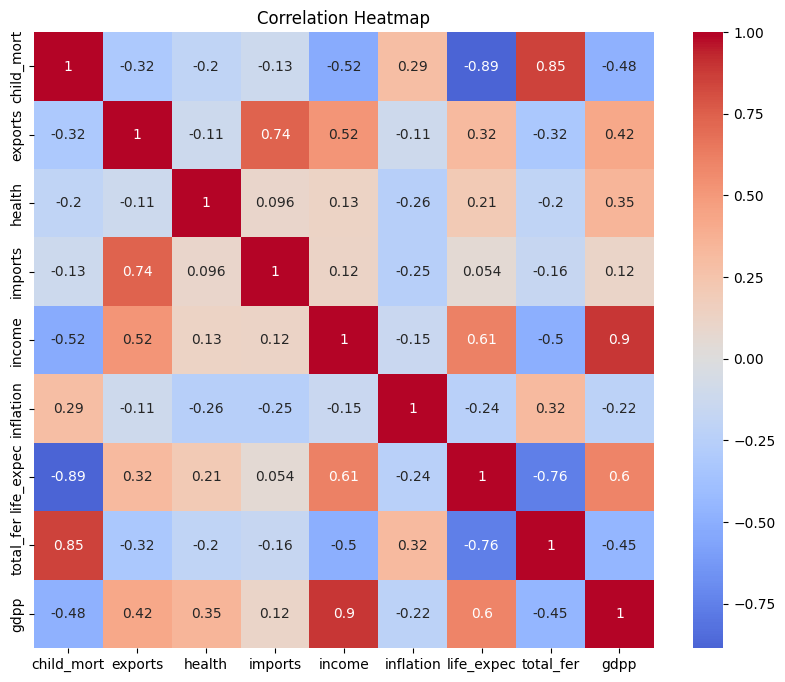

In [18]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


Income shows the strongest correlation with gdpp

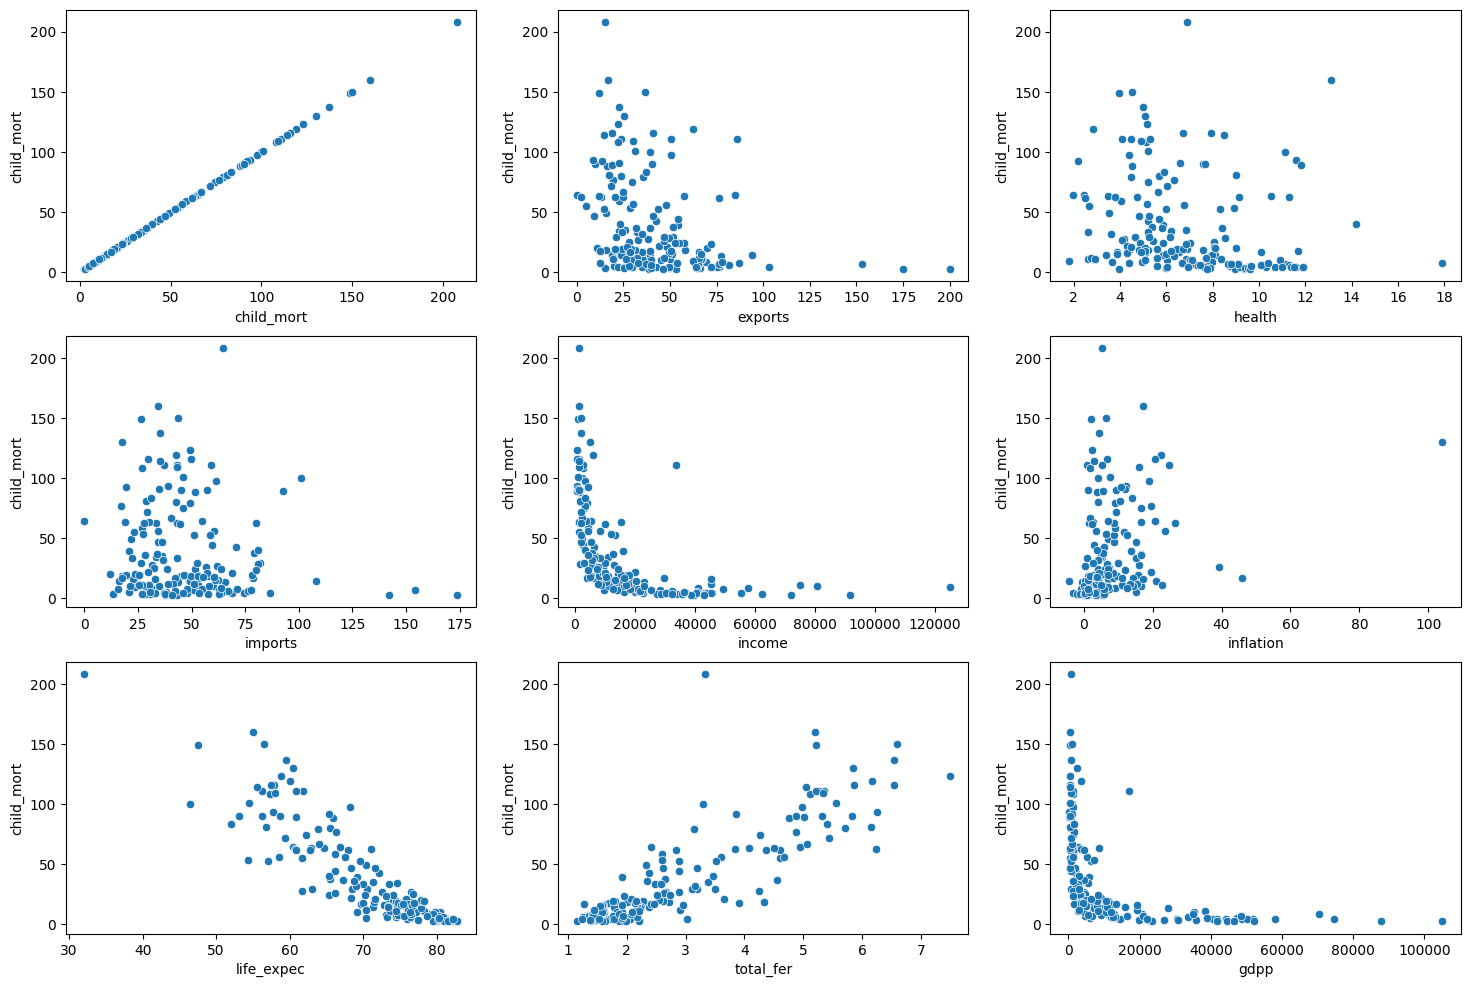

In [10]:
# Explore the continuous independent features against child_mort using scatter plots.
columns = data.columns.tolist()

fig, axes = plt.subplots(3, 3, figsize=(18,12))

axes = axes.flatten()

for i, var in enumerate(columns):
    sns.scatterplot(ax= axes[i], x = data[var], y=data['child_mort'])

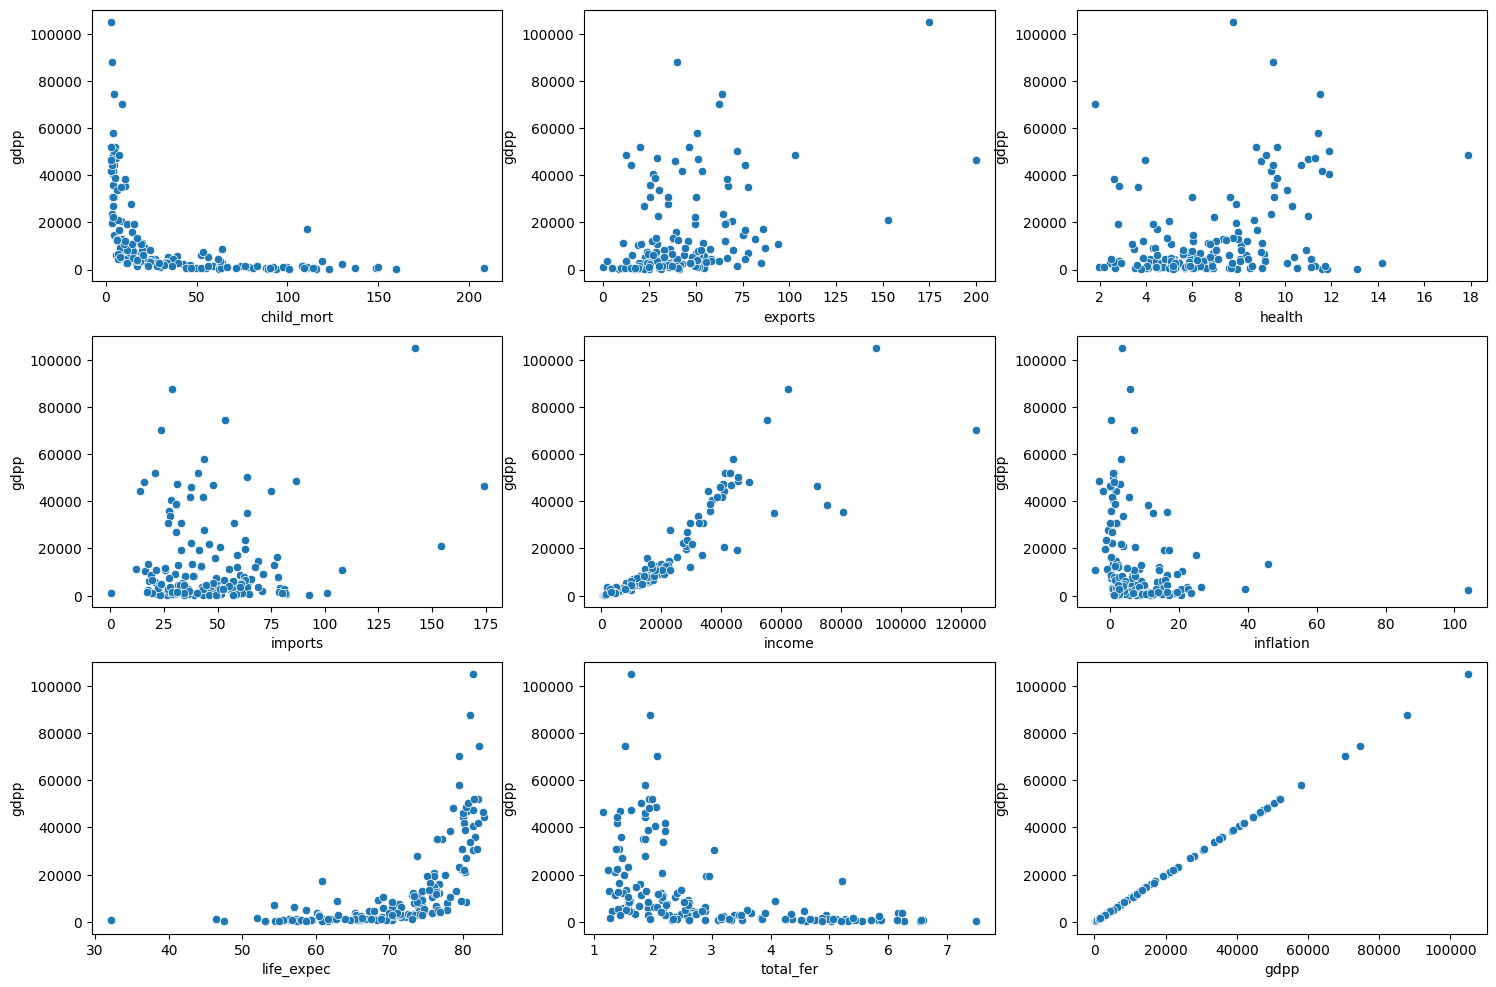

In [11]:
# Explore the continuous independent features against gdpp using scatter plots.
fig, axes = plt.subplots(3, 3, figsize=(18,12))

axes = axes.flatten()

for i, var in enumerate(columns):
    sns.scatterplot(ax= axes[i], x = data[var], y=data['gdpp'])

Inflation, for example, has a good pontential for a cluster as the observations are very close to one another.

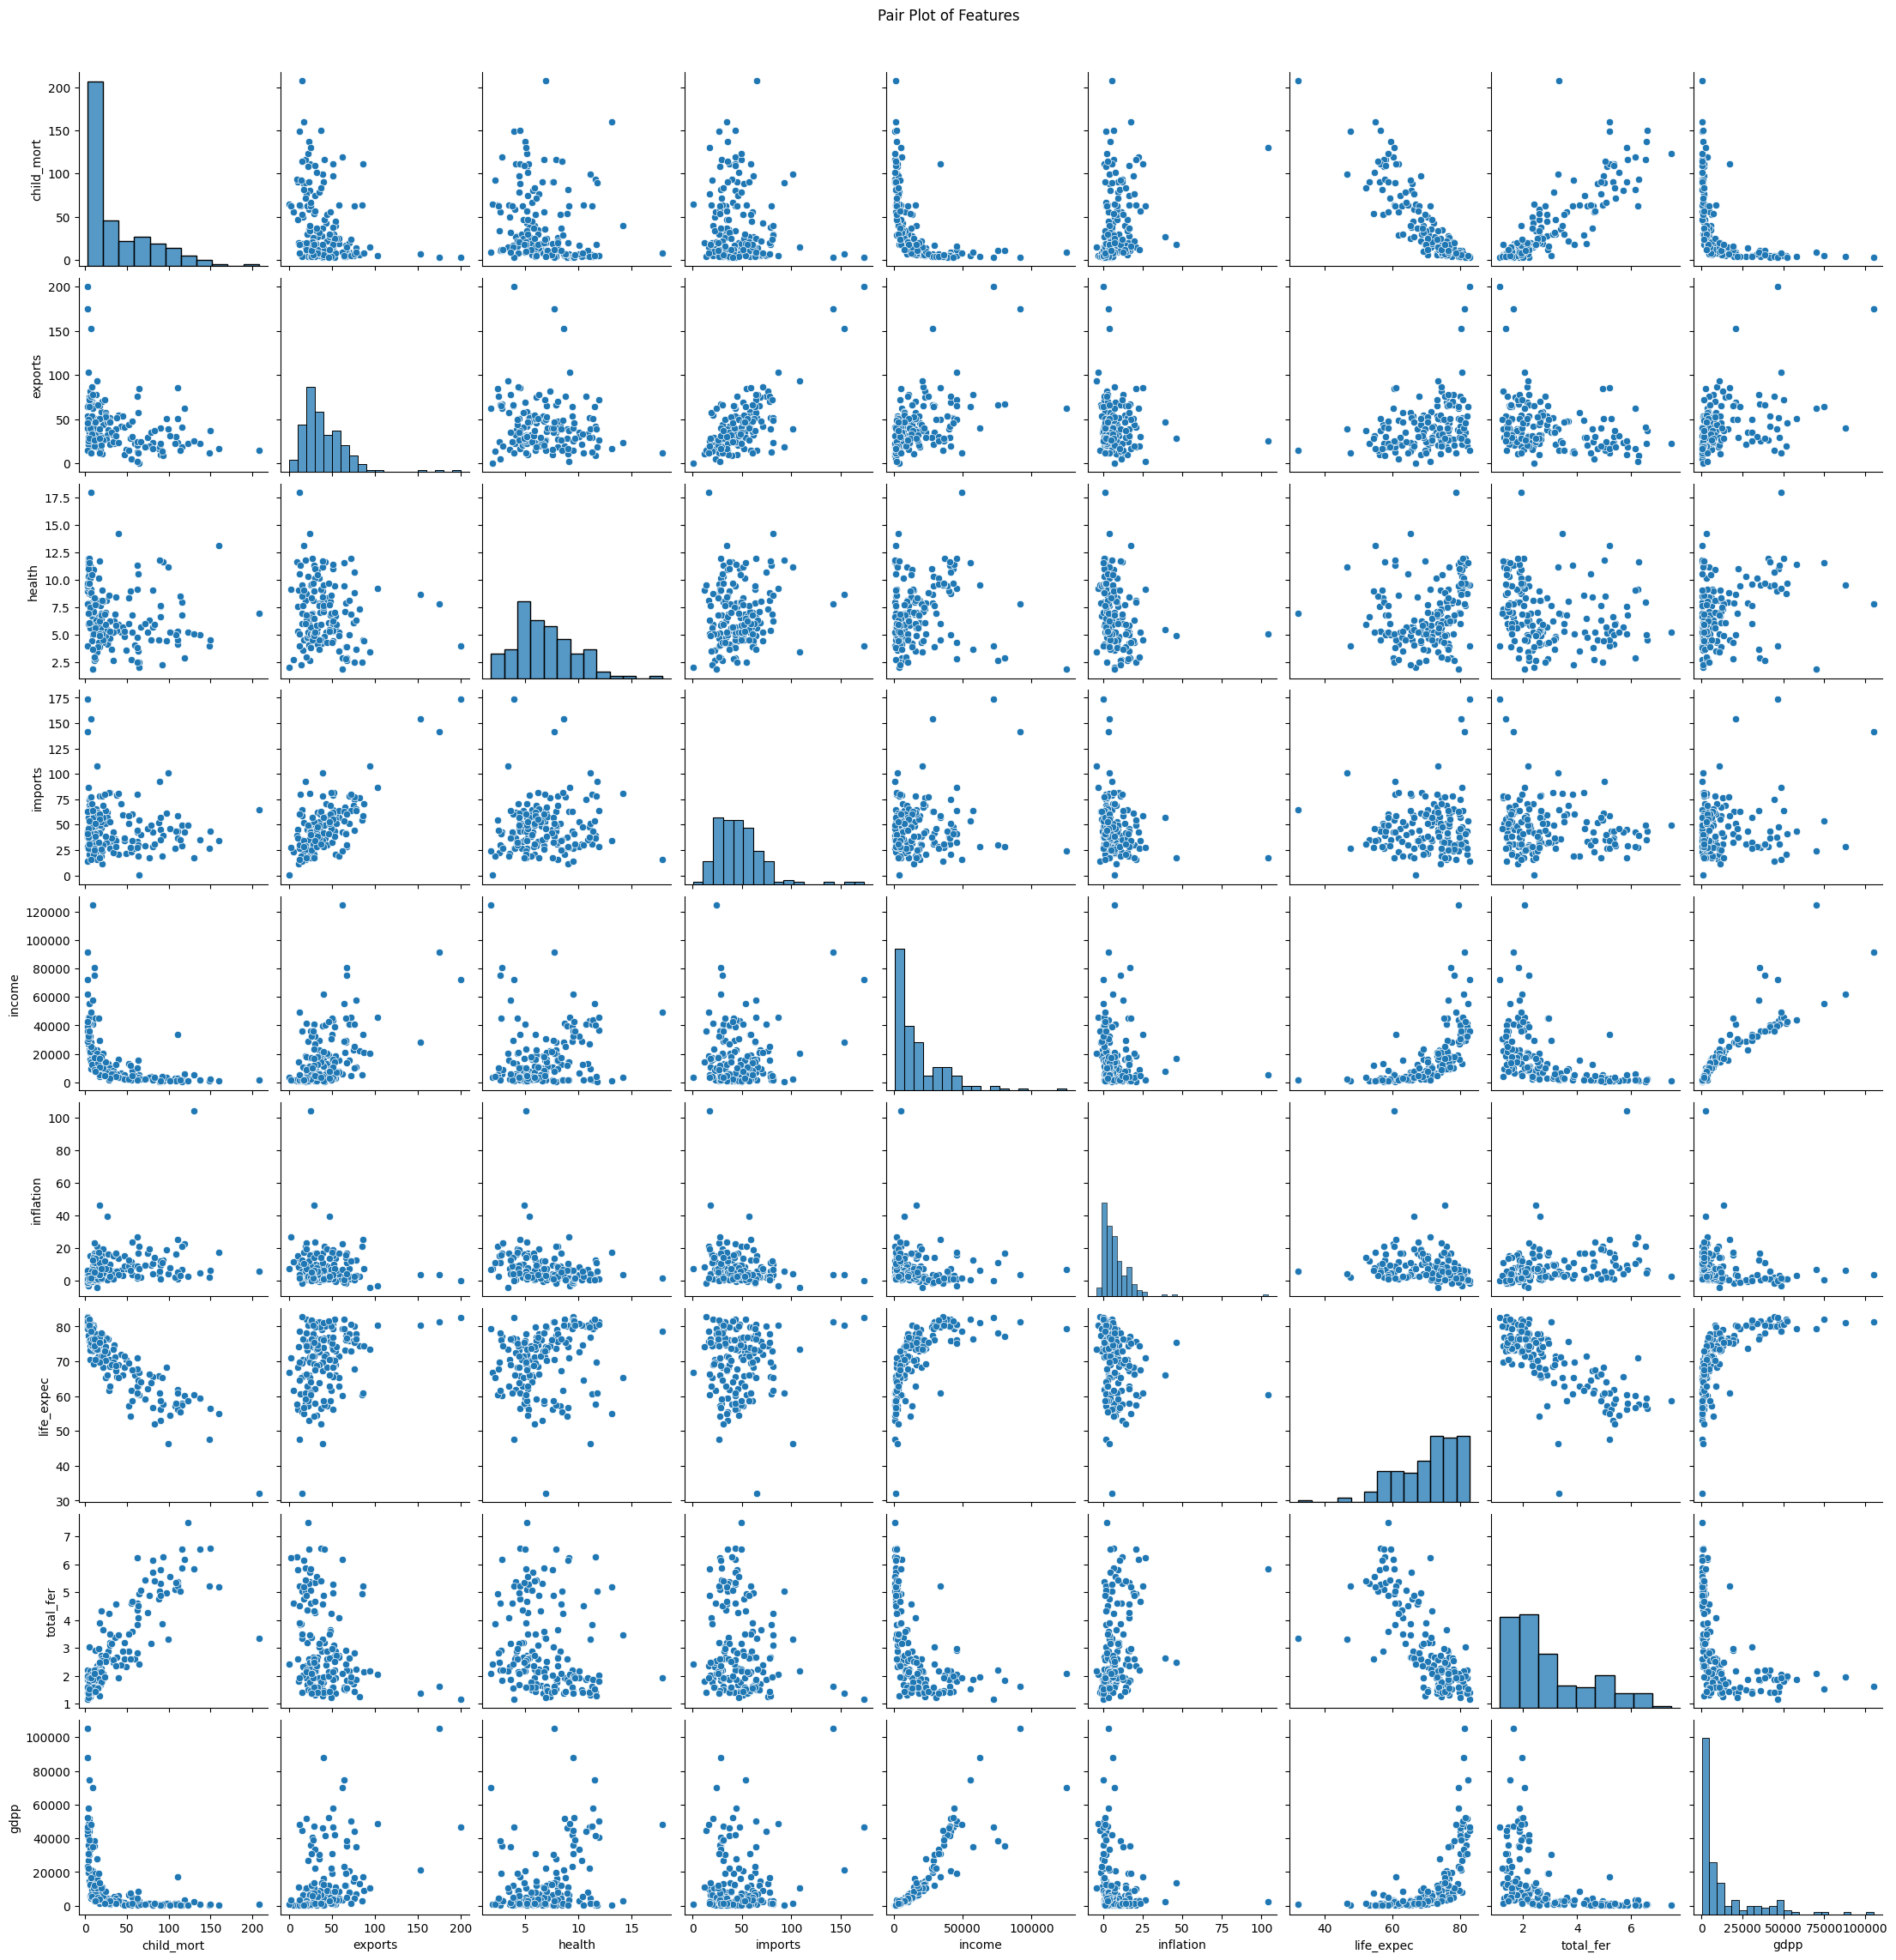

In [19]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(data)
plt.suptitle('Pair Plot of Features', y=1.02)  
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [20]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(data)

## K-Means Clustering

### Selecting K

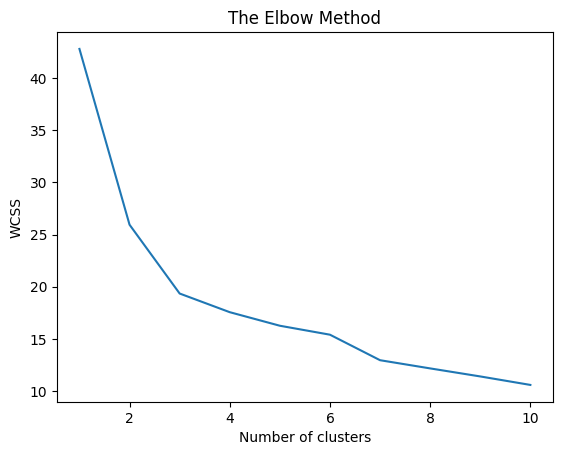

In [21]:
# Plot elbow curve

# Deciding the number of clusters k; use elbow method
wcss = []

# For each n_clusters, i, get the inertia
for i in range(1, 11): # 1 to 10 clusters
        kmeans = KMeans(n_clusters = i, random_state = 42)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)

# Visualisation
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

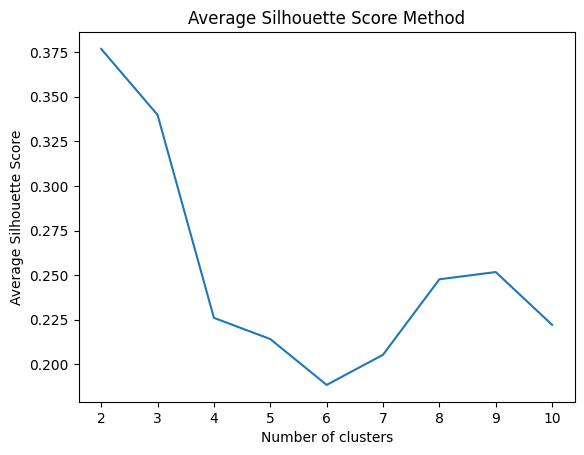

In [23]:
silhouette_scores = []

# For each n_clusters, i, get the avg silhouette
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_scaled)

    silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Visualisation
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score Method')
plt.show()

Based on the elbow and silhouette score method the value for K is 2

## Fitting a K-Means Model with the selected K value

In [24]:
# Remember to set the random_state to rseed
kmeans = KMeans(n_clusters=2, random_state=rseed)
kmeans.fit(df_scaled)

KMeans(n_clusters=2, random_state=42)

In [27]:
# Check model performance with the silhouette coefficient
labels = kmeans.labels_
score = silhouette_score(df_scaled, labels)
score

0.37671430588173554

0.377 is not the best silhouette score as ideally the value should be as close to 1 as possible.

## Predictions

In [ ]:
# Add the predicted cluster label column to the original dataframe
df = pd.DataFrame(df_scaled, columns=columns)
df['Cluster'] = labels

## Visualisation of clusters

<Axes: xlabel='child_mort', ylabel='gdpp'>

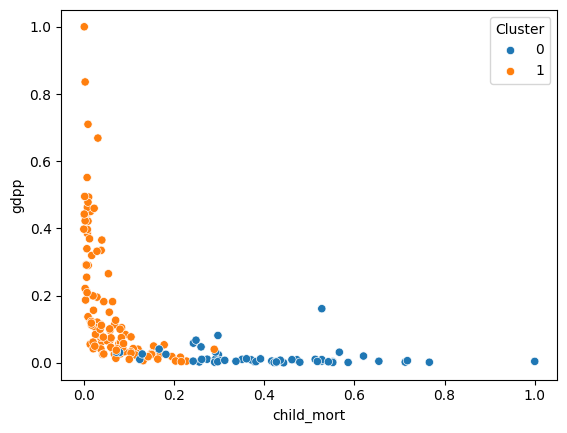

In [53]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(x=df['child_mort'], y=df['gdpp'], hue=df['Cluster'])

<Axes: xlabel='inflation', ylabel='gdpp'>

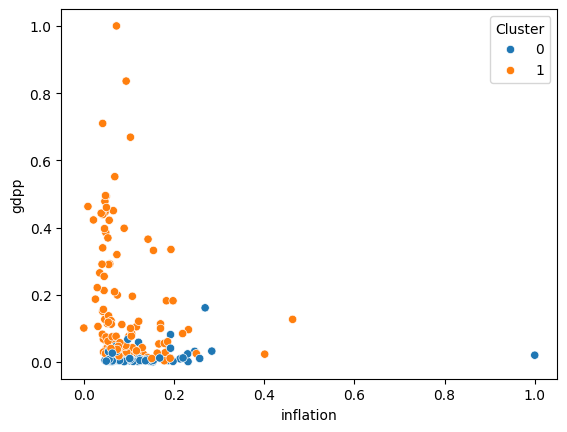

In [52]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x=df['inflation'], y=df['gdpp'], hue=df['Cluster'])

In [54]:
df.groupby('Cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,0.401469,0.142143,0.285044,0.250841,0.026381,0.141749,0.555998,0.573846,0.016459
1,0.061791,0.236034,0.323903,0.278226,0.185258,0.095632,0.857935,0.141055,0.173135


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**<br>
Countries in 'Cluster 0' are least developed as they have high child mortality, higher inflation and low gdpp <br>
Countries in 'Cluster 1' are more developed with low child mortality, lower inflation and high gdpp.

In [28]:
profile_dict = {
    'age':28
}

profile_age = len(profile_dict['age'])
print(profile_age)

TypeError: object of type 'int' has no len()